In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.utils  import plot_model
from tensorflow.keras.losses import mse

In [79]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

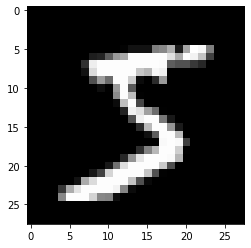

In [80]:
plt.imshow(X_train[0])

In [81]:
# 타입 변환
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255

In [82]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [83]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilong = tf.keras.backend.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilong

In [84]:
encoder_inputs = keras.Input(shape=(28 * 28))
x = layers.Dense(256, activation = 'relu')(encoder_inputs)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dense(64, activation = 'relu')(x)
x = layers.Dense(16, activation = 'relu')(x)
z_mean = layers.Dense(2, name="z_mean")(x)
z_log_var = layers.Dense(2, name="z_log_var")(x)

In [85]:
z = Sampling()([z_mean,z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var,z], name="encoder")


# 입력 받아서 z_mean(평균), z_log_var(표준편차 로그값), z(분포에 포함되는 샘플)


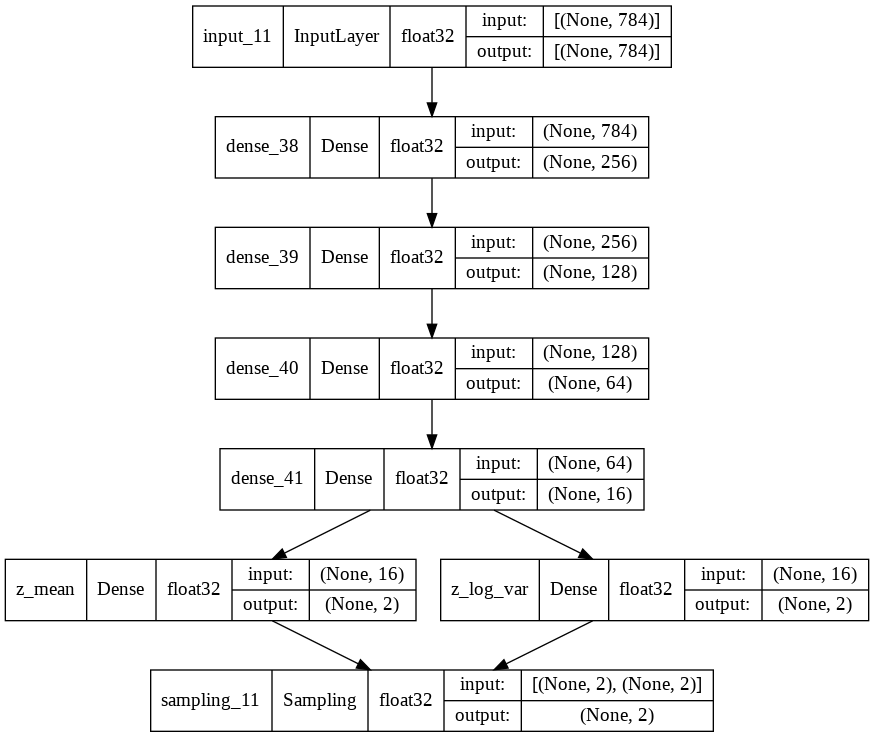

In [86]:
plot_model(encoder, show_shapes=True, show_dtype=True)

In [87]:
latent_inputs = keras.Input(shape=(2,))
x = layers.Dense(16, activation="relu")(latent_inputs)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
decoder_outputs = layers.Dense(28*28, activation="sigmoid")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

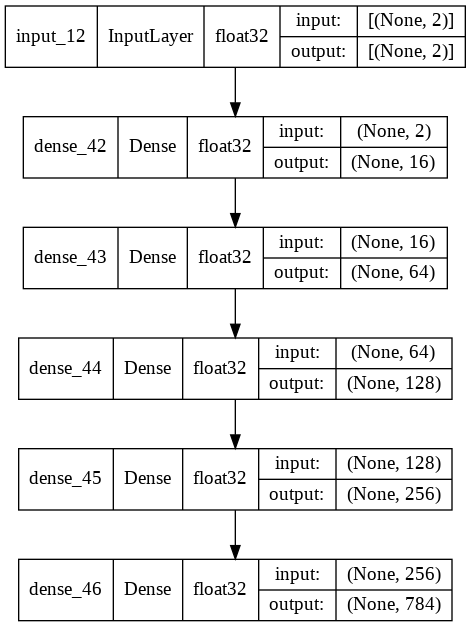

In [88]:
plot_model(decoder, show_shapes=True, show_dtype=True)

In [89]:
# Variational Autoencoder 객체 선언
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        #객체 생성시 실행되는 함수
       
        super(VAE, self).__init__(**kwargs)
         #인코더와 디코더를 입력 받아서 속성에 저장  
        self.encoder = encoder
        self.decoder = decoder
    
    # 학습할때 실행되는 함수
    # 매개변수 data : 학습, 테스트 데이터
    def train_step(self, data):
        # tf.GradientTape() 기울기를 계산해서 weight를 수정할 객체 리턴
        with tf.GradientTape() as tape:
            #입력을 받아서 z_mean(평균), z_log_var(표준편차 로그값), z (분포에 포함되는 샘플) 을 리턴받는 모델 생성
            z_mean, z_log_var, z = self.encoder(data)
            # 2칸의 데이터(2개의 샘플데이터)를 입력 받아서 28*28 출력 (생성 이미지)
            reconstruction = self.decoder(z)
            # 원본이미지와 생성 이미지의 차를 계산  
            reconstruction_loss = mse(data, reconstruction)
            # 오차에 데이터 수를 곱해서 값을 키워줌
            reconstruction_loss *= (28 * 28)
            # 실제 데이터의 분포 p(x) 와 encoder가 추정한 분포 q(x) 사이의 차를 계산
            kl_loss = -0.5*(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var) )
            # 실제 데이터의 분포 p(x) 와 encoder가 추정한 분포 q(x) 사이의 오차의 평균
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=-1))
            # reconstruction_loss (원본과 생성 이미지의 오차) + kl_loss (실제 데이터의 분포 p(x) 와 encoder가 추정한 분포 q(x) 사이의 오차)
            total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        # 기울기 계산    
        grads = tape.gradient(total_loss, self.trainable_weights)
        # weight 업데이트
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # 학습할때 마다 화면에 출력하는 값
        return {
             # reconstruction_loss (원본과 생성 이미지의 오차) + kl_loss (실제 데이터의 분포 p(x) 와 encoder가 추정한 분포 q(x) 사이의 오차) 리턴
            "total_loss": total_loss,
            # 원본이미지와 생성 이미지의 오차 리턴
            "reconstruction_loss": reconstruction_loss,
             # 실제 데이터의 분포 p(x) 와 encoder가 추정한 분포 q(x) 사이의 오차 리턴
            "kl_loss": kl_loss
        }

In [90]:
# 학습데이터를 28*28 칸으로 수정
X_train = X_train.reshape(-1,28*28)

# 테스트 데이터를 28*28 칸으로 수정
X_test = X_test.reshape(-1, 28* 28)

# Variational Autoencoder 객체 생성
vae = VAE(encoder, decoder)

# Variational Autoencoder 옵티마이저 설정
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))


In [91]:
# Variational Autoencoder학습
vae.fit(X_train, epochs=10, shuffle=True, batch_size=1000)

Epoch 1/10
60/60 [==============================] - 1s 4ms/step - total_loss: 80.4843 - reconstruction_loss: 78.4227 - kl_loss: 2.0615
Epoch 2/10
60/60 [==============================] - 0s 4ms/step - total_loss: 52.3118 - reconstruction_loss: 51.7251 - kl_loss: 0.5867
Epoch 3/10
60/60 [==============================] - 0s 4ms/step - total_loss: 50.8515 - reconstruction_loss: 49.7011 - kl_loss: 1.1505
Epoch 4/10
60/60 [==============================] - 0s 4ms/step - total_loss: 48.3734 - reconstruction_loss: 46.2360 - kl_loss: 2.1374
Epoch 5/10
60/60 [==============================] - 0s 4ms/step - total_loss: 47.0527 - reconstruction_loss: 44.5361 - kl_loss: 2.5166
Epoch 6/10
60/60 [==============================] - 0s 4ms/step - total_loss: 45.6057 - reconstruction_loss: 42.8581 - kl_loss: 2.7476
Epoch 7/10
60/60 [==============================] - 0s 4ms/step - total_loss: 44.2802 - reconstruction_loss: 41.3106 - kl_loss: 2.9696
Epoch 8/10
60/60 [==============================] - 0s 

In [92]:
# X_test에서 z_mean(평균), z_log_var (표준편차의 로그값), z(분포에서 선택한 샘플 2개씩)
z_mean, z_log_var, z = vae.encoder(X_train[0:10])

In [93]:
# z를 이용하여 이미지 생성
generate_data = vae.decoder(z)

In [94]:
generate_data

<tf.Tensor: shape=(10, 784), dtype=float32, numpy=
array([[5.5926008e-04, 5.2424148e-04, 6.8276381e-04, ..., 9.4567583e-04,
        3.5501801e-04, 7.0670585e-04],
       [5.6461936e-06, 7.7573432e-06, 4.7675758e-06, ..., 5.6230933e-06,
        3.6940505e-06, 4.3371138e-06],
       [5.9176815e-05, 1.4065209e-04, 1.3285862e-04, ..., 9.1629066e-05,
        9.4406962e-05, 1.0322883e-04],
       ...,
       [1.5855689e-03, 1.4391204e-03, 1.9903907e-03, ..., 2.4464617e-03,
        1.1837663e-03, 1.8475727e-03],
       [4.0717971e-09, 3.0454785e-09, 3.3503667e-08, ..., 3.7673210e-08,
        1.8210652e-09, 2.1282263e-08],
       [1.6326679e-06, 2.2878910e-06, 4.4475164e-06, ..., 4.6355913e-06,
        2.6718340e-06, 5.9071285e-06]], dtype=float32)>

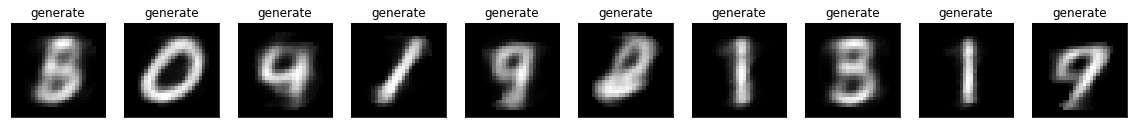

In [95]:
n = 10
# 그래프의 가로 세로 설정
plt.figure(figsize=(20, 4))
#10번 반복
for i in range(n):
  # 1줄 10칸중에 i+1번째 이미지 출력 준비
  ax = plt.subplot(1, n, i + 1)
  plt.title("generate")
  # 생성 이미지 출력
  plt.imshow( generate_data[i].numpy().reshape(28,28) )
  # 흑백으로 줄력
  plt.gray()
  #x축 좌표가 출력되지 않도록 설정
  ax.get_xaxis().set_visible(False)
  #y축 좌표가 출력되지 않도록 설정
  ax.get_yaxis().set_visible(False)